## Final Project Submission

Please fill out:
* Student name: 
* Student pace: self paced / part time / full time
* Scheduled project review date/time: 
* Instructor name: 
* Blog post URL:


# Phase 2. Beyond Fast Track
Goal of Phase 2 is to get a final model addressing all issues and inaccuracies encountered during Phase 1(Fast Track)

## Fast Track Conclusions
R squared = 66%. The linear model explains 66% of the variations in the house price. 
The model tends to under predict (predicted value < actual value), especially on the high end of the price range 
Training and test performances seem close based on visualization, but Mean Square Error (MSE) for test is 22% higher than for the training set. 
Presence of outliers is evidenced by the prediction errors visualization. They are likely to be responsible for a good part of the inaccuracy of the model. Needs to be addressed in forthcoming work.

## Workflow:
1. address non-numerical data
2. Address the issue due to the presence of outliers  
3. Address potential collinearity between features  
4. Features selection step 1 
5. Address the issue of missing values  
6. Address categorical data  
7. Features selection step 2  
8. Features transformation and scaling  
9. test/train split or K fold cross validation
10. QC and Check assumptions: Linearity/ Model Residuals are normally distrib/ Homoscedasticity


## Importing needed modules, libraries ...

In [664]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import seaborn as sns

## Data import

In [665]:
dfull = pd.read_csv('kc_house_data.csv')
df=dfull.copy()

In [666]:
# how many data points(rows)? How many variables (columns)?
df.shape

(21597, 21)

# Looking for duplicated entries

In [667]:
#Flag duplicates with True (if any)
df.duplicated().value_counts()

False    21597
dtype: int64

In [668]:
#No duplicates in the data

## Reminder  
Target variable (i.e. independent variable) = 'price'  
21597 raw data points
20 potential descriptors

# 1. Looking for non-numerical data 

In [669]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int64(11), object(2)
memory usage: 3.5+ MB


In [670]:
# columns 'date' and 'sqft_basement' are non numerical
# what is the data type of sqft_basement?
type(df['sqft_basement'][0])

str

In [671]:
# checking unique values of column sqft_basement
np.sort(df['sqft_basement'].unique())

array(['0.0', '10.0', '100.0', '1000.0', '1008.0', '1010.0', '1020.0',
       '1024.0', '1030.0', '1040.0', '1050.0', '1060.0', '1070.0',
       '1080.0', '1090.0', '110.0', '1100.0', '1110.0', '1120.0',
       '1130.0', '1135.0', '1140.0', '1150.0', '1160.0', '1170.0',
       '1180.0', '1190.0', '120.0', '1200.0', '1210.0', '1220.0',
       '1230.0', '1240.0', '1245.0', '1248.0', '1250.0', '1260.0',
       '1270.0', '1275.0', '1280.0', '1281.0', '1284.0', '1290.0',
       '130.0', '1300.0', '1310.0', '1320.0', '1330.0', '1340.0',
       '1350.0', '1360.0', '1370.0', '1380.0', '1390.0', '140.0',
       '1400.0', '1410.0', '1420.0', '143.0', '1430.0', '1440.0', '145.0',
       '1450.0', '1460.0', '1470.0', '1480.0', '1481.0', '1490.0',
       '150.0', '1500.0', '1510.0', '1520.0', '1525.0', '1530.0',
       '1540.0', '1548.0', '1550.0', '1560.0', '1570.0', '1580.0',
       '1590.0', '160.0', '1600.0', '1610.0', '1620.0', '1630.0',
       '1640.0', '1650.0', '1660.0', '1670.0', '1680.0',

In [672]:
# column sqft_basement has multiple question marks instead of values!!
# check number of records with ? as sqft_basement
df['sqft_basement'].value_counts()

0.0       12826
?           454
600.0       217
500.0       209
700.0       208
          ...  
666.0         1
2350.0        1
704.0         1
4130.0        1
1816.0        1
Name: sqft_basement, Length: 304, dtype: int64

In [673]:
# How many '?' in sqft_basement column? in %
print( "% of '?' in column sqft_basement : ",100* len(df[df['sqft_basement']=='?'])/len(df) ) 
print( "# of '?' in column sqft_basement : ", len(df[df['sqft_basement']=='?']) )

% of '?' in column sqft_basement :  2.1021438162707784
# of '?' in column sqft_basement :  454


### Rationale: 
#### According to definitions of variables we should have:
#### sqft_basement = sqft_living -sqft_above

In [674]:
# let's check sqft_basement = sqft_living -sqft_above
# select only rows without ? in sqft_basement
# copy of df to avoid chained indexing warning
df2=df.loc[ df['sqft_basement'] != '?' ].copy()
# change type of sqft_basement to float64
df2['sqft_basement']=df2['sqft_basement'].astype('float64')

# compute sqft_basement according to formula and compare to given sqft_basement
df2['sqft_basement2'] =  df2['sqft_living'] -df2['sqft_above']
df2['sqft_bas_diff'] = df2['sqft_basement2'] - df2['sqft_basement']

df2['sqft_bas_diff'].describe()

count    21143.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: sqft_bas_diff, dtype: float64

In [675]:
# Ok at this point we could  replace '?' by the calculated value  sqft_living -sqft_above
print('check before: ',df['sqft_basement'].iloc[18])
df.loc[df['sqft_basement'] == '?',['sqft_basement']] = df['sqft_living']-df['sqft_above']
print('check after: ',df['sqft_basement'].iloc[18])


check before:  ?
check after:  0


In [676]:
# check
print( "# of '?' in column sqft_basement : ", len(df[df['sqft_basement']=='?']) )

# of '?' in column sqft_basement :  0


### Rationale: 
At this point we could  replace '?' in sqft_basement  by the calculated value  sqft_living -sqft_above
But, we would get 3 variables such as each one can be derived from the other 2. This is a situation of perfect multicollinearity similar to the dummy variable trap.
The right thing to do is to drop one f the 3 variables.


In [678]:
# we drop sqft_basement
df = df.drop(['sqft_basement'],axis = 1)

In [679]:
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [490]:
# check date column. type?
print(df.date[0])
type(df.date[0])


10/13/2014


str

In [491]:
# change date type to datetime
# then, keep only the year from 'date' (date it was sold) and make it an integer
df['date']=pd.to_datetime(df['date']).dt.year.astype('int')


In [492]:
# checking  date now
df['date'][0:5]

0    2014
1    2014
2    2015
3    2014
4    2015
Name: date, dtype: int32

## Looking for NaN values


In [493]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21143 entries, 0 to 21596
Data columns (total 21 columns):
id               21143 non-null int64
date             21143 non-null int32
price            21143 non-null float64
bedrooms         21143 non-null int64
bathrooms        21143 non-null float64
sqft_living      21143 non-null int64
sqft_lot         21143 non-null int64
floors           21143 non-null float64
waterfront       18804 non-null float64
view             21082 non-null float64
condition        21143 non-null int64
grade            21143 non-null int64
sqft_above       21143 non-null int64
sqft_basement    21143 non-null float64
yr_built         21143 non-null int64
yr_renovated     17389 non-null float64
zipcode          21143 non-null int64
lat              21143 non-null float64
long             21143 non-null float64
sqft_living15    21143 non-null int64
sqft_lot15       21143 non-null int64
dtypes: float64(9), int32(1), int64(11)
memory usage: 4.1 MB


### NaN values issues with waterfront, view, yr_renovated

In [494]:
# Let's check waterfront
print( 'values in waterfront : ', df['waterfront'].unique() )
print(  '% of NaN in waterfront : ', 100*(len(df) - np.sum(df['waterfront'].value_counts()))  / len(df) )
print( '% of 0 in waterfront : ', 100*(np.sum(df['waterfront'].value_counts()[0]))  / len(df) )
print( '% of 1 in waterfront : ',100*(np.sum(df['waterfront'].value_counts()[1]))  / len(df) )

values in waterfront :  [nan  0.  1.]
% of NaN in waterfront :  11.062763089438585
% of 0 in waterfront :  88.26561982689306
% of 1 in waterfront :  0.6716170836683536


In [495]:
# 11 % of the values in waterfront are Nan
# as the majority of houses are not waterfrnt( 88% of zeroes), we will replace NaN with zero
df['waterfront'] = df['waterfront'].fillna(0)

In [496]:
# Let's check waterfront again
print( 'values in waterfront : ', df['waterfront'].unique() )
print(  '% of NaN in waterfront : ', 100*(len(df) - np.sum(df['waterfront'].value_counts()))  / len(df) )
print( '% of 0 in waterfront : ', 100*(np.sum(df['waterfront'].value_counts()[0]))  / len(df) )
print( '% of 1 in waterfront : ',100*(np.sum(df['waterfront'].value_counts()[1]))  / len(df) )

values in waterfront :  [0. 1.]
% of NaN in waterfront :  0.0
% of 0 in waterfront :  99.32838291633165
% of 1 in waterfront :  0.6716170836683536


In [497]:
# Let's check view
print( 'values in view : ', df['view'].unique() )


values in view :  [ 0. nan  3.  4.  2.  1.]


In [498]:
# 'view' is supposed to mean whether the data has been viewed. 
# This does not make sense to me  as the data stops in 2015 
# So we drop this feature 'view'

In [499]:
# check most recent year for house sold:
df['date'].max()

2015

In [500]:
# drop column 'view'
df.drop('view',axis =1, inplace = True)

In [501]:
# check # of columns was reduced to 20
df.shape

(21143, 20)

In [502]:
# check yr_renovated
# print all distinct values
print( 'values in yr_renovated : ', df['yr_renovated'].unique() )
print(  'occurences for each distinct value in yr_renovated : ', df['yr_renovated'].value_counts() )
print(  '% of 0 in yr_renovated: ' , 100* np.sum(df['yr_renovated'].value_counts()[0]) / len(df) )
print(  '% of NaN in yr_renovated: ' , 100* (len(df)  - np.sum(df['yr_renovated'].value_counts()) ) / len(df) )

values in yr_renovated :  [   0. 1991.   nan 2002. 2010. 1992. 2013. 1994. 1978. 2005. 2003. 1984.
 1954. 2014. 2011. 1983. 1945. 1990. 1988. 1977. 1981. 1995. 2000. 1999.
 1998. 1970. 1989. 2004. 1986. 2007. 1987. 2006. 1985. 1980. 1971. 1979.
 1997. 1950. 1969. 1948. 2009. 2015. 1974. 2008. 1968. 2012. 1963. 1951.
 1962. 2001. 1953. 1993. 1996. 1955. 1982. 1956. 1940. 1976. 1975. 1964.
 1973. 1957. 1959. 1960. 1967. 1965. 1934. 1972. 1944. 1958.]
occurences for each distinct value in yr_renovated :  0.0       16666
2014.0       69
2003.0       31
2013.0       31
2007.0       30
          ...  
1953.0        1
1944.0        1
1934.0        1
1971.0        1
1959.0        1
Name: yr_renovated, Length: 69, dtype: int64
% of 0 in yr_renovated:  78.82514307335761
% of NaN in yr_renovated:  17.755285437260557


In [503]:
# As there is a majority of yr_renovated = 0 (79%) and 18% of the values are NaN, 
# we will replace NaN by the mode: 0
df['yr_renovated'].fillna(value =0,inplace = True)

In [504]:
# check 
print( 'values in yr_renovated : ', df['yr_renovated'].unique() )

print(  '% of 0 in yr_renovated: ' , 100* np.sum(df['yr_renovated'].value_counts()[0]) / len(df) )
print(  '% of NaN in yr_renovated: ' , 100* (len(df)  - np.sum(df['yr_renovated'].value_counts()) ) / len(df) )

values in yr_renovated :  [   0. 1991. 2002. 2010. 1992. 2013. 1994. 1978. 2005. 2003. 1984. 1954.
 2014. 2011. 1983. 1945. 1990. 1988. 1977. 1981. 1995. 2000. 1999. 1998.
 1970. 1989. 2004. 1986. 2007. 1987. 2006. 1985. 1980. 1971. 1979. 1997.
 1950. 1969. 1948. 2009. 2015. 1974. 2008. 1968. 2012. 1963. 1951. 1962.
 2001. 1953. 1993. 1996. 1955. 1982. 1956. 1940. 1976. 1975. 1964. 1973.
 1957. 1959. 1960. 1967. 1965. 1934. 1972. 1944. 1958.]
% of 0 in yr_renovated:  96.58042851061818
% of NaN in yr_renovated:  0.0


In [505]:
# for yr_renovated, 0 doesn't make sense.
# We will replace 0 by the year the house was built. 
# This will enable yr_renovated to be used as a predictor
df['yr_renovated'] = df[['yr_renovated','yr_built']].max(axis=1)

In [506]:
# check
df['yr_renovated'].value_counts()

2014.0    611
2005.0    464
2006.0    463
2003.0    446
2004.0    443
         ... 
1901.0     27
1902.0     26
1933.0     24
1935.0     19
1934.0     15
Name: yr_renovated, Length: 116, dtype: int64

### We created inadvertently a heavy correlation between yr_correlated and yr_built. 
### We will only keep the predictor that has the highest correlation to price.
### Check correlation:

In [507]:
df_check = df[['yr_renovated','yr_built','price']]
df_check.corr()

,yr_renovated,yr_built,price
yr_renovated,1.000000,0.927086,0.097086
yr_built,0.927086,1.000000,0.054459
price,0.097086,0.054459,1.000000


### The correlation of price with yr_renovated is much bigger (9.7%) as the correlation between price and yr_built (5.4%). Therefore we keep only yr_renovated and remove yr_built.
### Note: the absolute values of these correlations are quite small. So this feature may end up being discarded later in the process anyway 

In [508]:
# remove yr_built column
df=df.drop('yr_built',axis = 1)

In [509]:
# check we don't have any NaN values left
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21143 entries, 0 to 21596
Data columns (total 19 columns):
id               21143 non-null int64
date             21143 non-null int32
price            21143 non-null float64
bedrooms         21143 non-null int64
bathrooms        21143 non-null float64
sqft_living      21143 non-null int64
sqft_lot         21143 non-null int64
floors           21143 non-null float64
waterfront       21143 non-null float64
condition        21143 non-null int64
grade            21143 non-null int64
sqft_above       21143 non-null int64
sqft_basement    21143 non-null float64
yr_renovated     21143 non-null float64
zipcode          21143 non-null int64
lat              21143 non-null float64
long             21143 non-null float64
sqft_living15    21143 non-null int64
sqft_lot15       21143 non-null int64
dtypes: float64(8), int32(1), int64(10)
memory usage: 3.8 MB


In [510]:
# copy of data without NaN
dfnum=df.copy()

# 1. Looking for non-numerical data    - done
# 2. Detect and Address Outliers

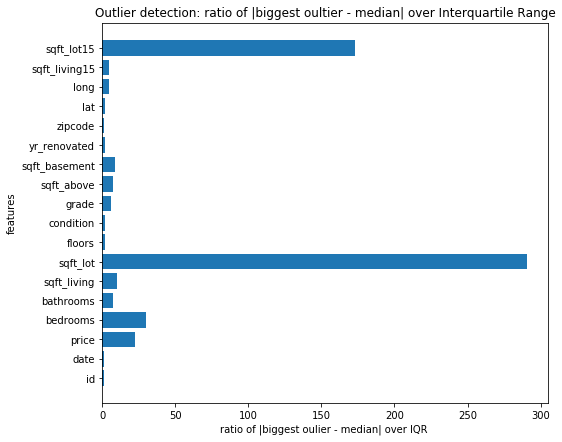

In [511]:
# detect ouliers using InterQuartile Range (IQR) 
dico={}
for col in df.columns:
    if df[col].quantile(.75) - df[col].quantile(.25)  != 0:
#         For features with IQR > 0, calculate the distance of the biggest outlier to the median 
        maxi=max(df[col].max() - df[col].median() ,  df[col].median() -df[col].min() )
#     divide by IQR 
        dico[col] = maxi  /  (df[col].quantile(.75) - df[col].quantile(.25))
# visualization of the ratio with a bar plot
plt.figure(figsize = (8,7))
plt.barh( list(dico.keys()) ,list(dico.values())  )
plt.xlabel('ratio of |biggest oulier - median| over IQR ')
plt.ylabel('features')
plt.title('Outlier detection: ratio of |biggest oultier - median| over Interquartile Range')
plt.show();

#### sqft_lot and sqft_lot15 have the "biggest" outliers. Let's check them first:

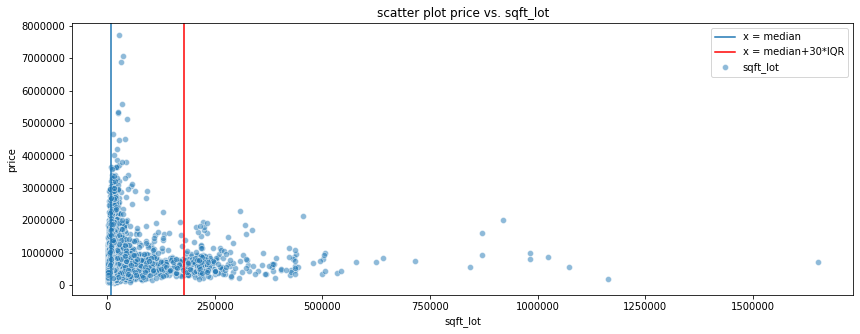

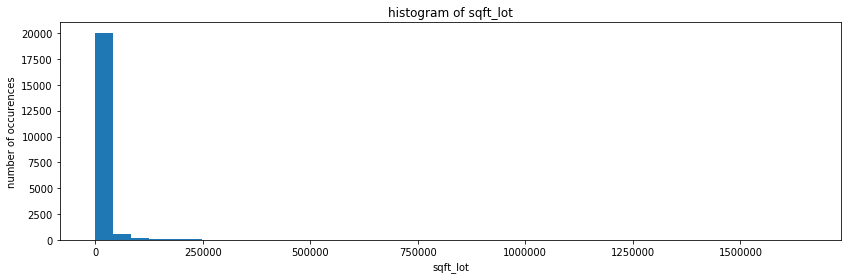

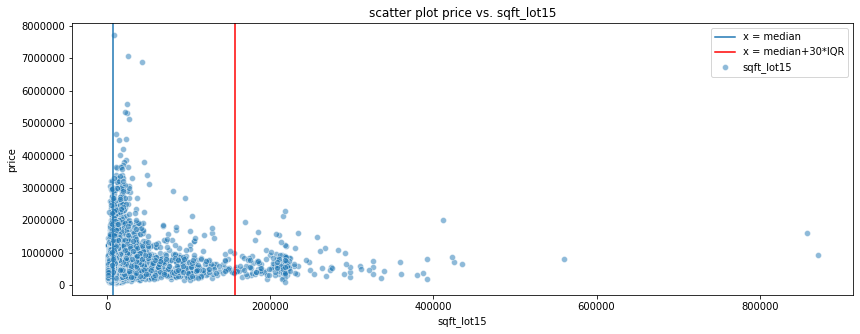

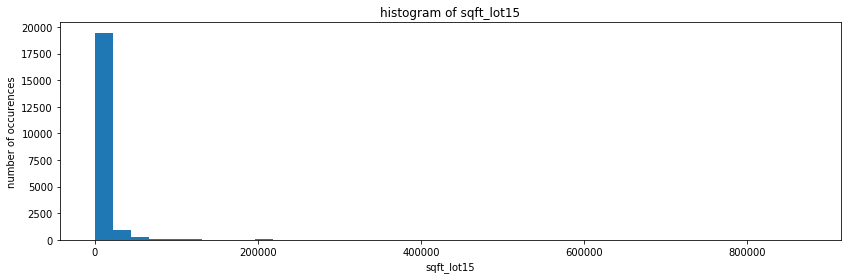

In [512]:
# Visualization of sqft_lot and sqft_lot15 vs the target variable price
df_plot = df[['price','sqft_lot','sqft_lot15']]

for feat in ['sqft_lot','sqft_lot15']:
    plt.figure(figsize=(14,5))
    sns.scatterplot(x=feat, y='price',data=df_plot,alpha=0.5,label = feat)
    plt.axvline(x=df_plot[feat].median(), label = 'x = median')
    IQR = df[feat].quantile(.75) - df[feat].quantile(.25)
    plt.axvline(x=df_plot[feat].median() + 30*IQR, label = 'x = median+30*IQR',color = 'r')
    plt.title('scatter plot price vs. {}'.format(feat))
    plt.legend()
    plt.show();  
    plt.figure(figsize=(14,4))
    plt.hist(df[feat],bins=40)
    plt.title('histogram of {}'.format(feat))
    plt.xlabel(feat)
    plt.ylabel('number of occurences')
    plt.show();

In [513]:
df_plot.corr()

,price,sqft_lot,sqft_lot15
price,1.000000,0.087937,0.083192
sqft_lot,0.087937,1.000000,0.720649
sqft_lot15,0.083192,0.720649,1.000000


## Conclusion for features sqft_lot and sqft_lot15
#### Very strong correlation between sqft_lot and sqft_lot15. ~72%
#### Very small correlation between sqft_lot(15) and target variable price
#### No linear relationship between sqft_lot(15) and target variable price
#### There are indeed outliers but it is of secondary importance compared to the observations above.
#### We will not use sqft_lot or sqft_lot15 for predicting price.

In [514]:
# remove sqft_lot and sqft_lot15 
df = df.drop(['sqft_lot','sqft_lot15'],axis = 1)

In [515]:
# check
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'floors',
       'waterfront', 'condition', 'grade', 'sqft_above', 'sqft_basement',
       'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15'],
      dtype='object')

## Back to the outliers:
### Let's look at the target

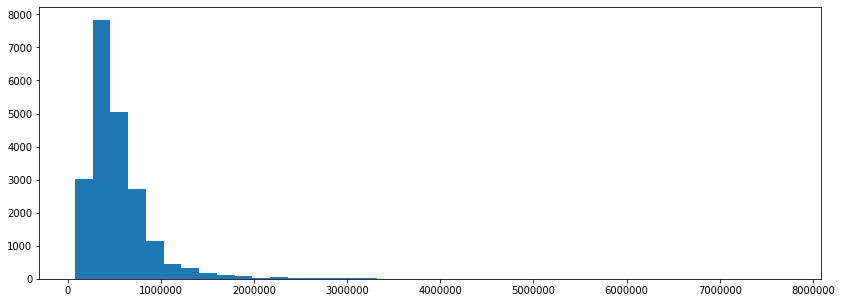

count    2.114300e+04
mean     5.405107e+05
std      3.680751e+05
min      7.800000e+04
25%      3.220000e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64

In [516]:
# histogram and Measure of central tendency
plt.figure(figsize=(14,5))
plt.hist(df['price'],bins=40)
plt.show();
df['price'].describe()

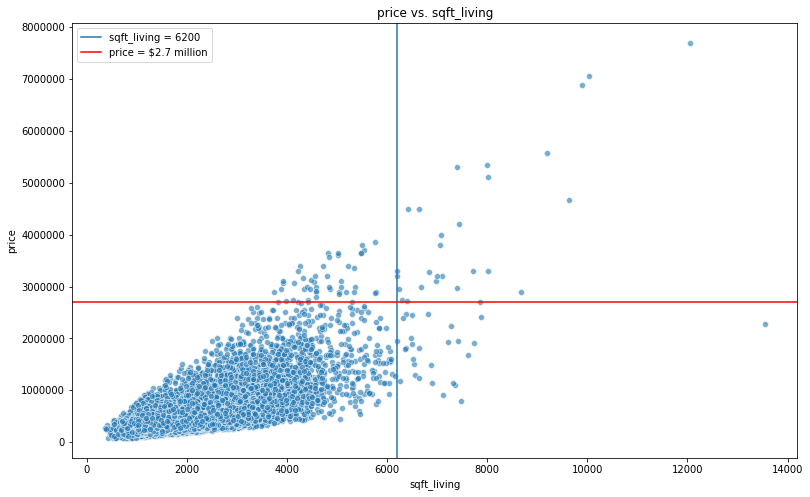

In [517]:
# scatterplot of price vs. sqft_living.
# Whysqft_living? Because sqft_living is the best correlation with price (identified so far)
df_plot2=df[['price','sqft_living']]
plt.figure(figsize=(13,8))
sns.scatterplot(x='sqft_living', y='price',data=df_plot2,alpha=0.6)
plt.axvline(x=6200, label=('sqft_living = 6200'))
plt.axhline(y=2700000, label=('price = $2.7 million'),color = 'r')
plt.title('price vs. sqft_living')
plt.legend()
plt.show();

## Rationale:
### The range of the prices goes very high, but we have very few data points over  2.7 million dollars. 
### When we plot price vs sqft_living as a  scatterplot, the cloud of points gets very scattered for sqft_living above above 6200 sqft
### From a business point of view, it could be nice to have a good model for very expensive houses to be on the high end of the market, but the scarcity of the data points makes this a difficult task. We will therefore focus on the low to mid range of the market, that we define by sqft_living < 6200 and price <3.5 million dollars.
### To get a reliable model past these thresholds, we would need more data.

In [518]:
print('shape before: ',df.shape)
df=df.loc[(df['sqft_living'] < 6200) & (df['price']<2700000)]
print('shape after: ',df.shape)

shape before:  (21143, 17)
shape after:  (21038, 17)


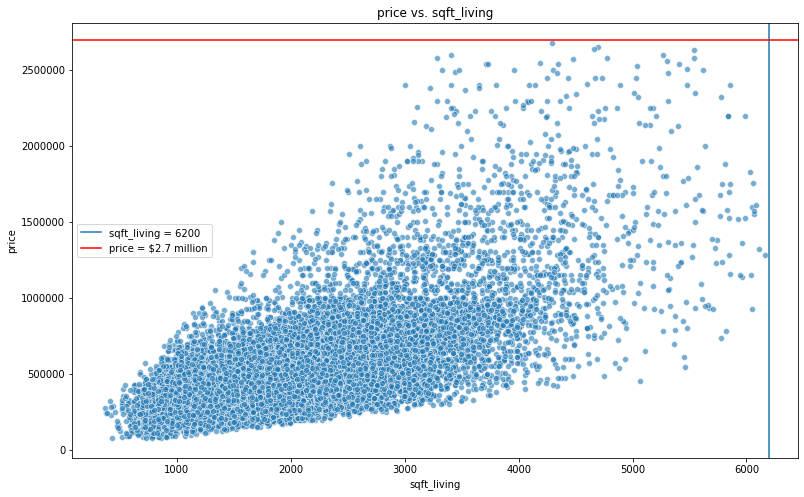

In [519]:
# checking ...
df_plot2=df[['price','sqft_living']]
plt.figure(figsize=(13,8))
sns.scatterplot(x='sqft_living', y='price',data=df_plot2,alpha=0.6)
plt.axvline(x=6200, label=('sqft_living = 6200'))
plt.axhline(y=2700000, label=('price = $2.7 million'),color = 'r')
plt.title('price vs. sqft_living')
plt.legend()
plt.show();

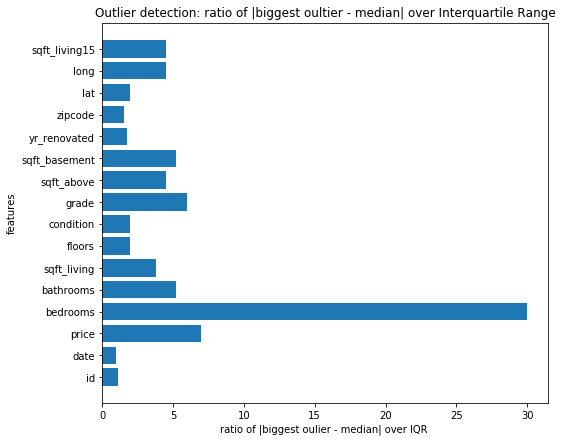

In [520]:
# Let's look at the same bar plot as before to detect ouliers using our latest updated data
# detect ouliers using InterQuartile Range (IQR) 
dico={}
for col in df.columns:
    if df[col].quantile(.75) - df[col].quantile(.25)  != 0:
#         For features with IQR > 0, calculate the distance of the biggest outlier to the median 
        maxi=max(df[col].max() - df[col].median() ,  df[col].median() -df[col].min() )
#     divide by IQR 
        dico[col] = maxi  /  (df[col].quantile(.75) - df[col].quantile(.25))
# visualization of the ratio with a bar plot
plt.figure(figsize = (8,7))
plt.barh( list(dico.keys()) ,list(dico.values())  )
plt.xlabel('ratio of |biggest oulier - median| over IQR ')
plt.ylabel('features')
plt.title('Outlier detection: ratio of |biggest oultier - median| over Interquartile Range')
plt.show();

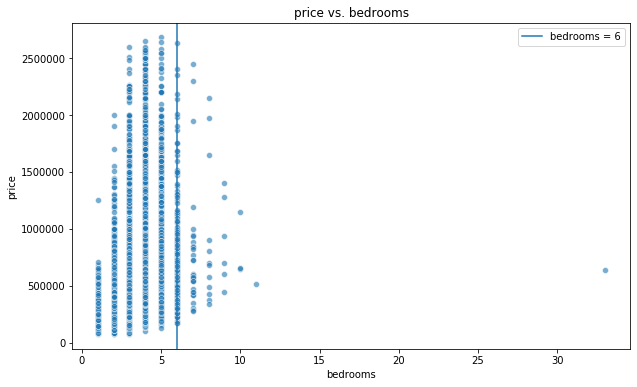

In [521]:
# let's check 'bedrooms'
# scatterplot of price vs. bedrooms.

df_plot2=df[['price','bedrooms']]
plt.figure(figsize=(10,6))
sns.scatterplot(x='bedrooms', y='price',data=df_plot2,alpha=0.6)
plt.axvline(x=6, label=('bedrooms = 6'))
# plt.axhline(y=3600000, label=('price = $3.6 million'),color = 'r')
plt.title('price vs. bedrooms')
plt.legend()
plt.show();

In [522]:
# Let's get rid of the single outlier with more than 30 bedrooms (!).
df = df.loc[df['bedrooms']< 30]

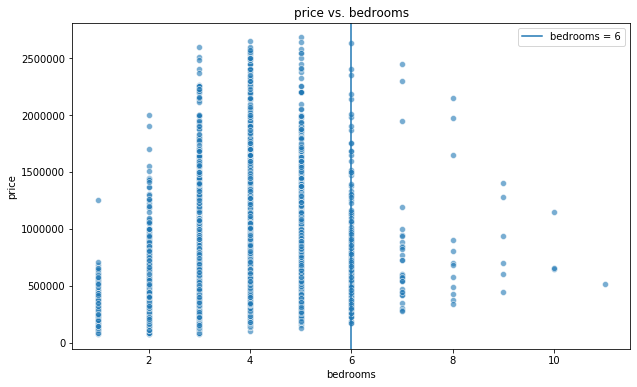

In [523]:
#Checking. Repeating the same plot from updated df
#scatterplot of price vs. bedrooms.

df_plot2=df[['price','bedrooms']]
plt.figure(figsize=(10,6))
sns.scatterplot(x='bedrooms', y='price',data=df_plot2,alpha=0.6)
plt.axvline(x=6, label=('bedrooms = 6'))
# plt.axhline(y=3600000, label=('price = $3.6 million'),color = 'r')
plt.title('price vs. bedrooms')
plt.legend()
plt.show();

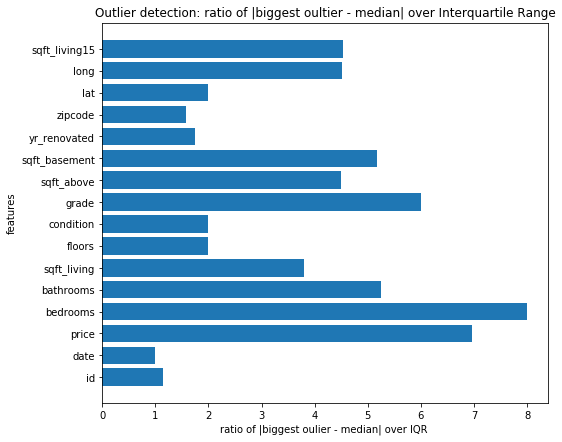

In [524]:
# Let's look at the same bar plot as before to detect ouliers using our latest updated data
# detect ouliers using InterQuartile Range (IQR) 
dico={}
for col in df.columns:
    if df[col].quantile(.75) - df[col].quantile(.25)  != 0:
#         For features with IQR > 0, calculate the distance of the biggest outlier to the median 
        maxi=max(df[col].max() - df[col].median() ,  df[col].median() -df[col].min() )
#     divide by IQR 
        dico[col] = maxi  /  (df[col].quantile(.75) - df[col].quantile(.25))
# visualization of the ratio with a bar plot
plt.figure(figsize = (8,7))
plt.barh( list(dico.keys()) ,list(dico.values())  )
plt.xlabel('ratio of |biggest oulier - median| over IQR ')
plt.ylabel('features')
plt.title('Outlier detection: ratio of |biggest oultier - median| over Interquartile Range')
plt.show();

## 1. Looking for non-numerical data - done
## 2. Detect and Address Outliers - done
## 3. Collinearity between features and correlation to target

In [525]:
# correlation between each column of df. 
# absolute value as we are only interested in the strength of the correlation, not the sign.
correl = np.abs(df.corr())
# Let's keep only correlation above 5%
correl_filt=correl > .05


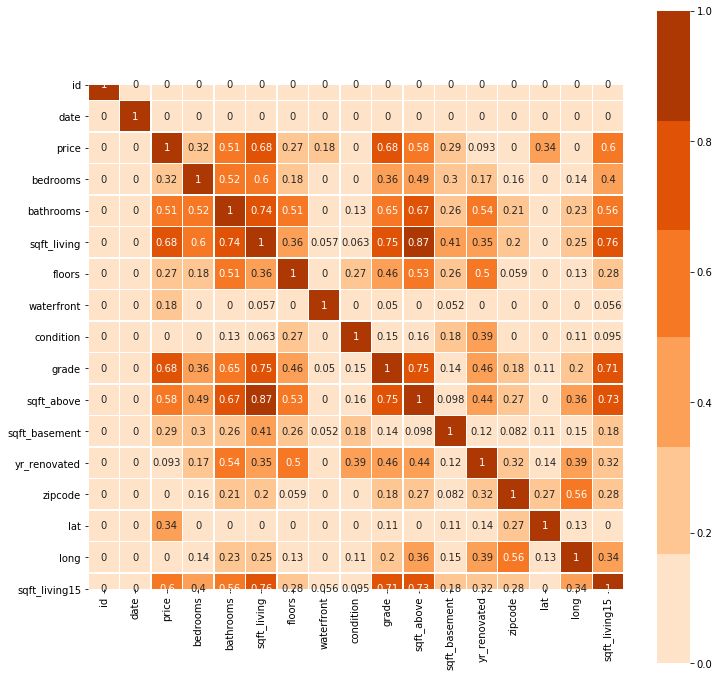

In [526]:
plt.figure(figsize=(12,12))
sns.heatmap(data=correl_filt*correl,cmap = sns.color_palette('Oranges'),annot = True,
#              fmt="f",
            cbar=True, center=.5,
            square = True, vmin=0, vmax=1,
           linewidths=.4,linecolor='white');

## Conclusion:
#### Good predictors uncorrelated with any other:                     waterfront, lat
#### Good predictors mildly correlated with others:                   yr_renovated, floors, sqft_basement, bedrooms, bathrooms 
#### Very Good predictors highly correlated with each other:   sqft_above, sqft_living,15, grade, sqft_living

#### For now we will keep only these predictors and the target

In [528]:
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'floors',
       'waterfront', 'condition', 'grade', 'sqft_above', 'sqft_basement',
       'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15'],
      dtype='object')

In [529]:
df = df.drop(['id', 'date','condition', 'zipcode', 'long'], axis = 1)

In [530]:
# check:
df.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'floors', 'waterfront',
       'grade', 'sqft_above', 'sqft_basement', 'yr_renovated', 'lat',
       'sqft_living15'],
      dtype='object')

## 1. Looking for non-numerical data - done
## 2. Detect and Address Outliers - done
## 3. Collinearity between features and correlation to target  - done
## 4. Additional Feature Selection

## rationale:
#### sqft_living = sqft_above + sqft_basement

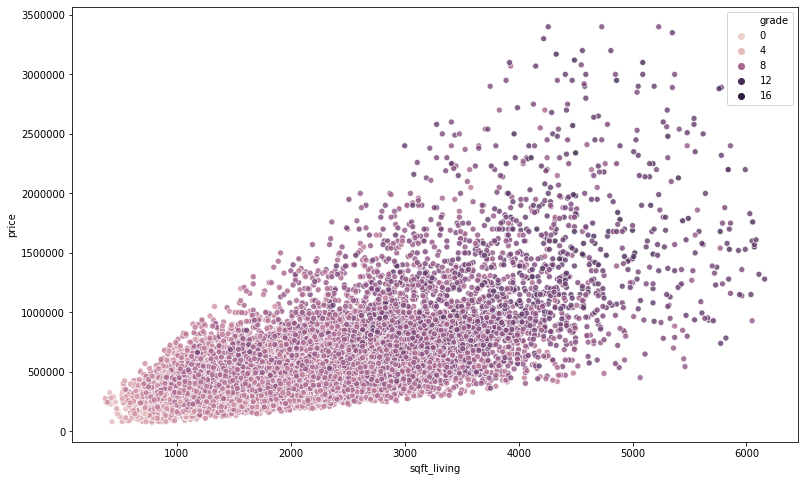

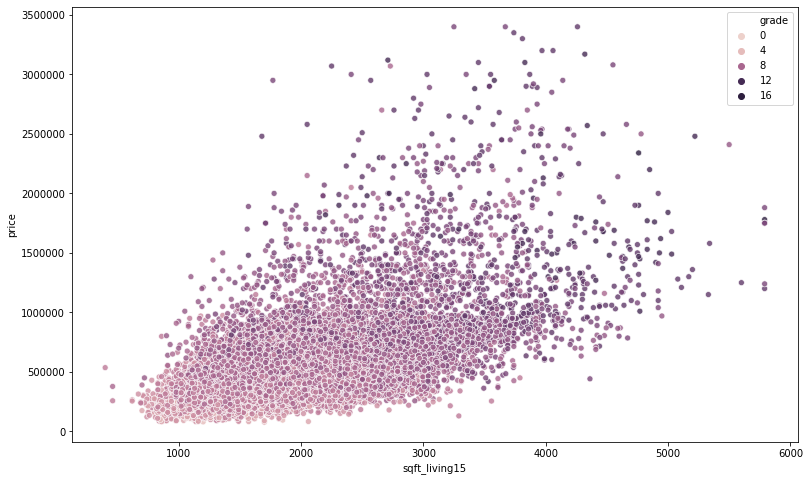

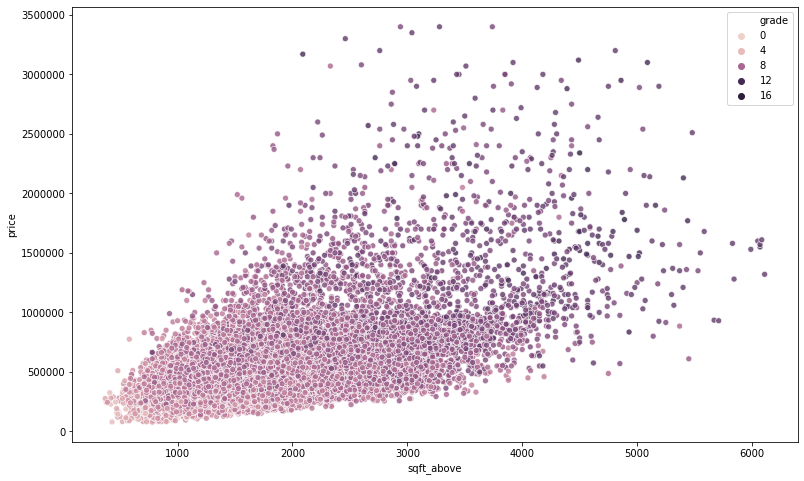

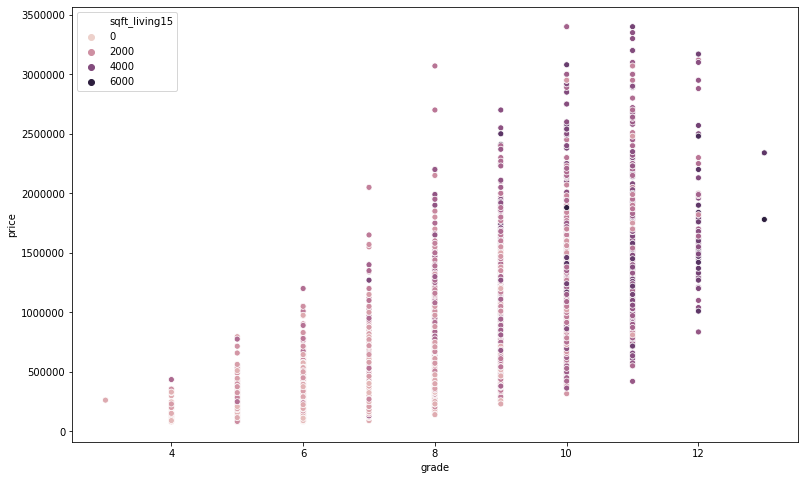

In [416]:
# visualization: scatterplot price vs each feature
plt.figure(figsize=(13,8))
sns.scatterplot( x=df['sqft_living'], y=df['price'], hue=df['grade'] ,alpha=0.8)
plt.show();

plt.figure(figsize=(13,8))
sns.scatterplot( x=df['sqft_living15'], y=df['price'], hue=df['grade'], alpha=0.8 )
plt.show();

plt.figure(figsize=(13,8))
sns.scatterplot( x=df['sqft_above'], y=df['price'], hue=df['grade'], alpha=0.8 )
plt.show();

plt.figure(figsize=(13,8))
sns.scatterplot( x=df['grade'], y=df['price'], hue=df['sqft_living15'] )
plt.show();


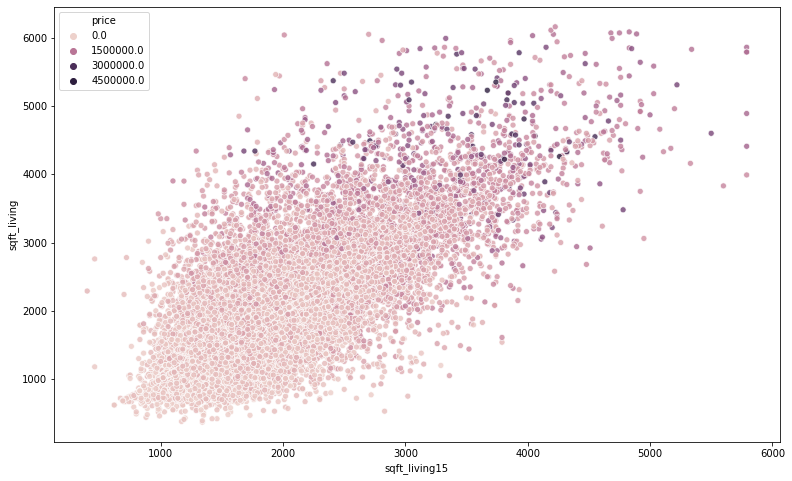

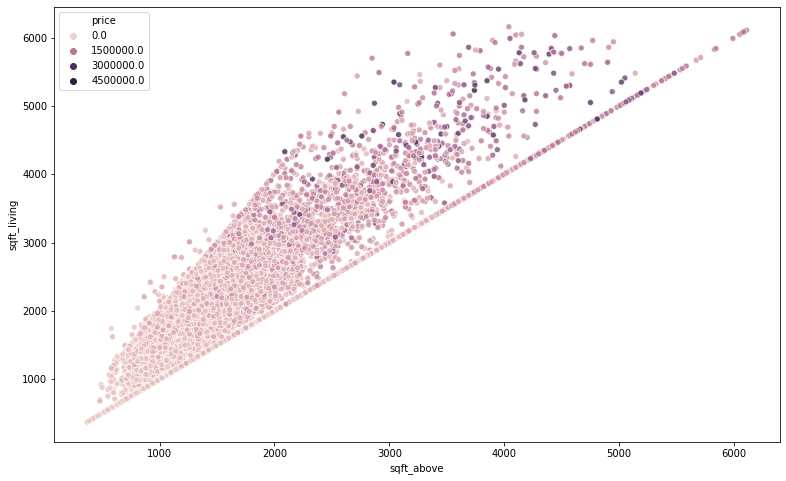

In [417]:
plt.figure(figsize=(13,8))
sns.scatterplot( x=df['sqft_living15'], y=df['sqft_living'], hue=df['price'] ,alpha=0.8)
plt.show();

plt.figure(figsize=(13,8))
sns.scatterplot( x=df['sqft_above'], y=df['sqft_living'], hue=df['price'] ,alpha=0.8)
plt.show();


### Conclusion:
#### For now we will only keep sqft_living and remove sqft_living15, sqft_above and grade because they are so heavily correlated with one another.

In [418]:
df['sqft']= df['sqft_living']+df['sqft_living15']+df['sqft_above'] 
df = df.drop(['sqft_living','sqft_living15', 'sqft_above' ], axis = 1)


In [359]:
# Removing features highly correlated with each other:
print('before: ', df.columns)
df = df.drop(['sqft_living15', 'sqft_above' , 'grade'], axis = 1)
print('after: ', df.columns)


before:  Index(['price', 'bedrooms', 'sqft_living', 'waterfront', 'grade', 'sqft_above',
       'sqft_basement', 'yr_renovated', 'lat', 'sqft_living15'],
      dtype='object')
after:  Index(['price', 'bedrooms', 'sqft_living', 'waterfront', 'sqft_basement',
       'yr_renovated', 'lat'],
      dtype='object')


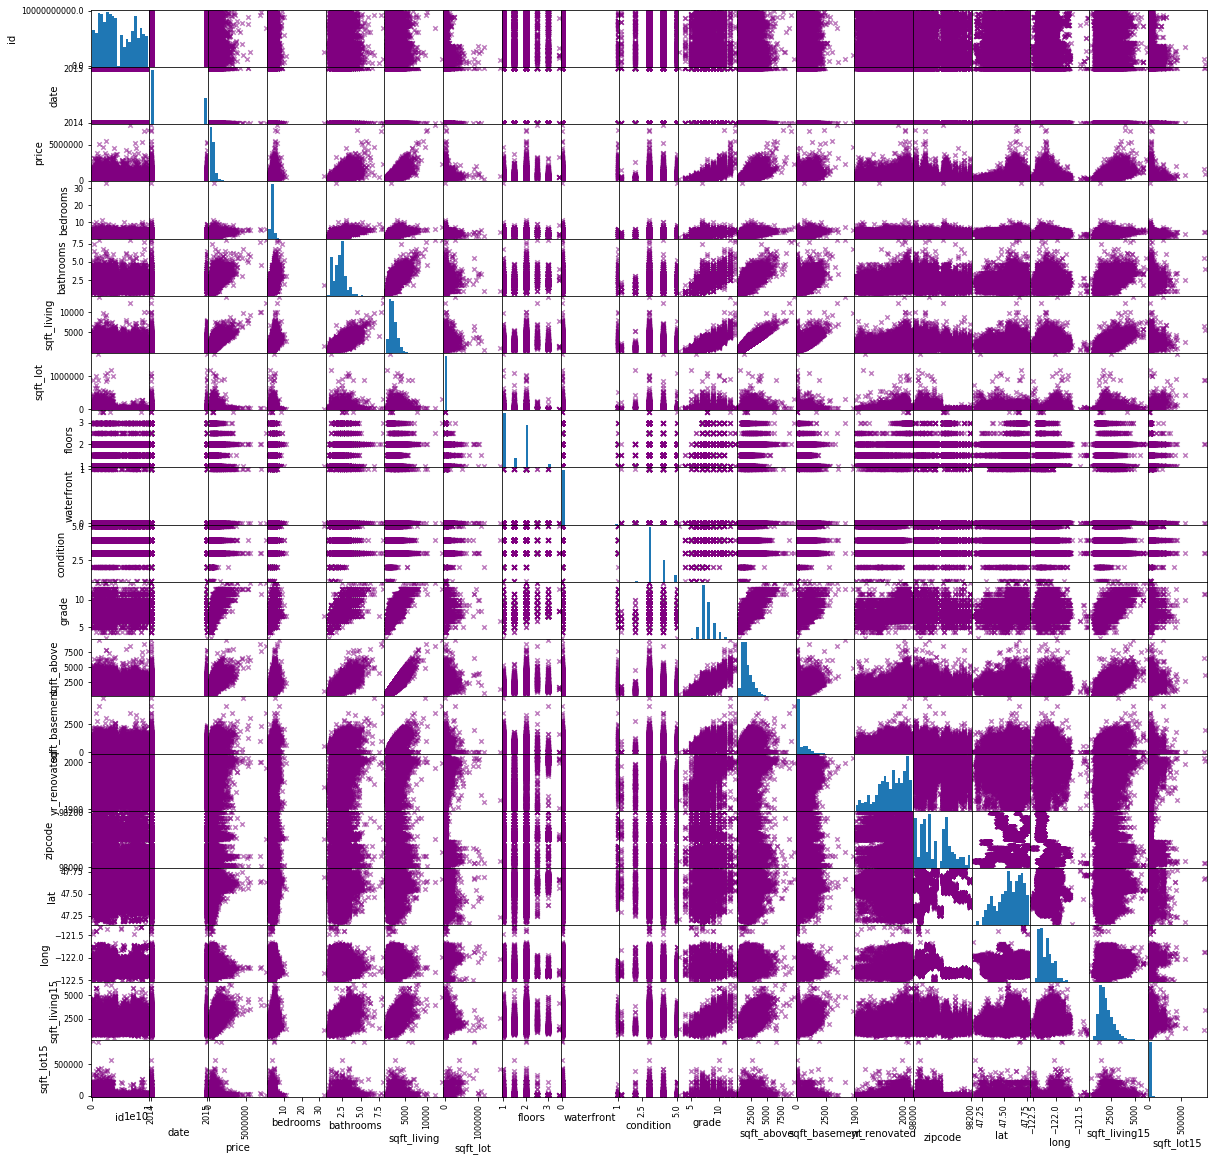

In [361]:
# scatter matricx to visually evaluate linear relationships between target and features
pd.plotting.scatter_matrix( dfnum,diagonal='hist' or 'kde',
                           figsize=(20,20),c='purple',
                           s=20,marker='x',
                           hist_kwds={'bins':20} )
plt.show();

## Train - Test Split

In [419]:
X= df.drop(['price'],axis=1)
y=df['price']

linreg = LinearRegression()
# Split the data randomly into training and test sets. 
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.2)

# check sizes
print( [ t.shape[:] for t in [X_train,X_test,y_train,y_test]])
print( X_test.shape[0]/( X_train.shape[0]+X_test.shape[0] ) )

[(16861, 7), (4216, 7), (16861,), (4216,)]
0.20002846704939034


## Multiple linear regression

In [420]:

X_train_int = sm.add_constant(X_train)  # contains all predictors and a constant column =1 for intercept
model = sm.OLS(y_train,X_train_int).fit() # y_train is a one column dataframe containing the dependent variable
model.summary()

C:\Users\poari\Anaconda3\envs\learn-env\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.664
Model:                            OLS   Adj. R-squared:                  0.664
Method:                 Least Squares   F-statistic:                     4753.
Date:                Wed, 08 Apr 2020   Prob (F-statistic):               0.00
Time:                        13:06:56   Log-Likelihood:            -2.2906e+05
No. Observations:               16861   AIC:                         4.581e+05
Df Residuals:                   16853   BIC:                         4.582e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -2.298e+07    5.6e+05    -41.031      0.000   -2.41e+07   -2.19e+07
bedrooms      -1.917e+04   2055.682     -9.324      0.000   -2.32e+04   -1.51e+04
waterfront     6.597e+05   1.97e+04     33.476      0.000    6.21e+05    6.98e+05
grade          1.087e+05   2267.435     47.942      0.000    1.04e+05    1.13e+05
sqft_basement    93.4368      3.670     25.457      0.000      86.242     100.631
yr_renovated  -2294.5274     60.572    -37.881      0.000   -2413.256   -2175.799
lat            5.647e+05   1.11e+04     50.851      0.000    5.43e+05    5.86e+05
sqft             66.5178      1.263     52.654      0.000      64.042      68.994
==============================================================================
Omnibus:                     9383.175   Durbin-Watson:                   2.023
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           150300.537
Skew:                           2.334   Prob(JB):                         0.00
Kurtosis:                      16.861   Cond. No.                     2.46e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.46e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Fast track QC 


In [421]:
# prediction for test  and training set:
X_test_int = sm.add_constant(X_test) # adds a constant column =1 for intercept (similar to X_train_int)
y_hat_test = model.predict(X_test_int)
y_hat_train = model.predict(X_train_int)

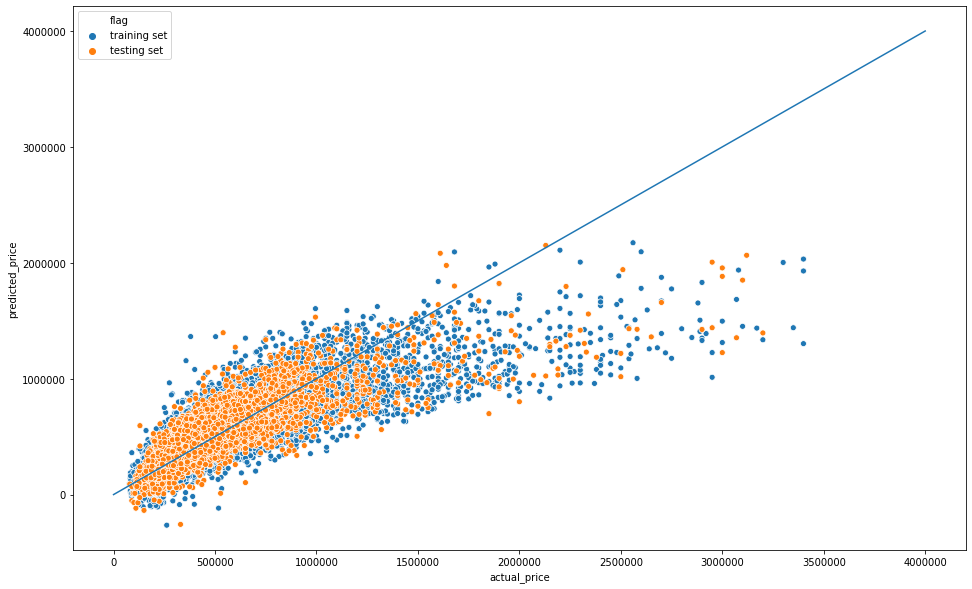

In [422]:
# visualization of residuals

# conversion of results for training set into a dataframe
y_train_df = pd.DataFrame(y_train)
y_hat_train_df = pd.DataFrame(y_hat_train)
y_train_df=pd.concat([y_train_df,y_hat_train_df],axis=1)
y_train_df.columns = ['actual_price','predicted_price']
y_train_df['flag']='training set'

# conversion of results for test set into a dataframe
y_test_df = pd.DataFrame(y_test)
y_hat_test_df = pd.DataFrame(y_hat_test)
y_test_df=pd.concat([y_test_df,y_hat_test_df],axis=1)
y_test_df.columns = ['actual_price','predicted_price']
y_test_df['flag']='testing set'

# putting together the training and test sets
y_plot = pd.concat ([y_train_df,y_test_df],axis = 0)

# scatter plot of training and test sets' predictions vs. actuals + line y=x for reference
plt.figure(figsize=(16,10))
sns.scatterplot(x='actual_price', y='predicted_price',hue ='flag',data=y_plot )
plt.plot([0,4000000],[0,4000000])
plt.show();

In [423]:
res_test=y_hat_test-y_test
res_train=y_hat_train-y_train

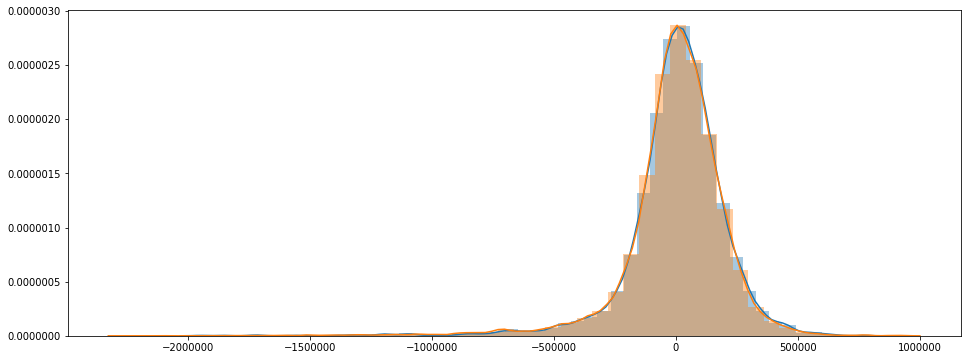

In [242]:
plt.figure(figsize=(16,6))
sns.distplot( res_test )
sns.distplot( res_train )
plt.show();

In [424]:

# Calculate mean square errors
train_mse = mean_squared_error(y_train,y_hat_train)
test_mse = mean_squared_error(y_test,y_hat_test) 
print ('train_mse :',train_mse)
print ('test_mse :',test_mse)
print ('difference (in %):  ', 100*(abs(train_mse-test_mse)) / train_mse)

train_mse : 36919671584.18091
test_mse : 37772255086.64834
difference (in %):   2.309293300519876
